In [0]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
train_csv = pd.read_csv('/content/drive/My Drive/Internshala/train_csv.csv',header=0,index_col=1,parse_dates=True)
train_csv.head()
#We set parse_dates to make sure data is read as time-series and make time column as Index

,id,feature
time,,
2019-03-19 00:00:00,0,237.97
2019-03-19 00:00:10,1,57.93
2019-03-19 00:00:20,2,90.53
2019-03-19 00:00:30,3,260.75
2019-03-19 00:00:40,4,49.70


In [3]:
train_csv.drop('id',axis=1,inplace=True)
train_csv.head()

,feature
time,
2019-03-19 00:00:00,237.97
2019-03-19 00:00:10,57.93
2019-03-19 00:00:20,90.53
2019-03-19 00:00:30,260.75
2019-03-19 00:00:40,49.70


## Visualize data

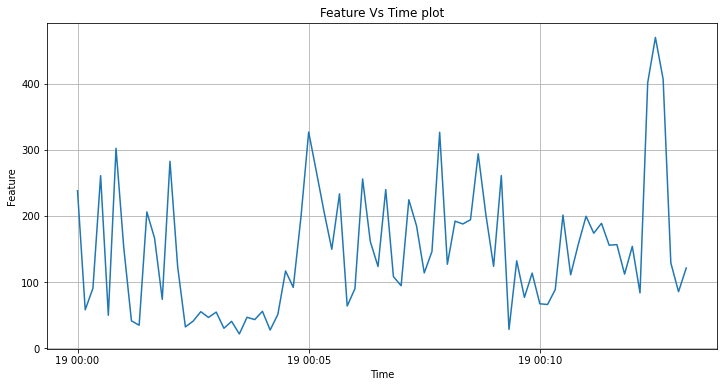

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(train_csv.index,train_csv['feature'])
plt.title('Feature Vs Time plot')
plt.xlabel('Time')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

Decompose graph for better understanding

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


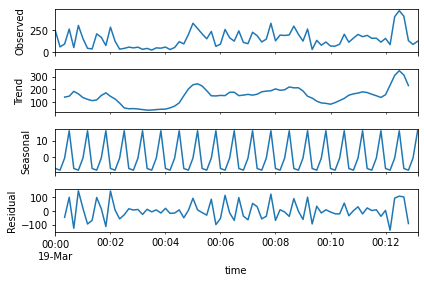

In [5]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
decompose_train = sm.tsa.seasonal_decompose(train_csv.feature,model='additive',freq=4)
decompose_train.plot()
plt.show()

This graphical representation depicts the slightly upward trend in the data.

In [0]:
# Splitting data to val and train
train = train_csv[0:int(len(train_csv)*0.7)]
val = train_csv[int(len(train_csv)*0.7):]

In [0]:
feature_train = train['feature']
feature_val = val['feature']

###**ARIMA model**

In [0]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

Perform dickey fuller test and verify null hypothesis that the TS is non-stationary

In [9]:
dftest = adfuller(feature_train)
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -2.019
DF test p-value is 0.2782


Since p-value > 0.05. Null Hypothesis cannot be rejected.
Let us try differencing, to make the time-series Stationary.

Text(0, 0.5, 'Feature')

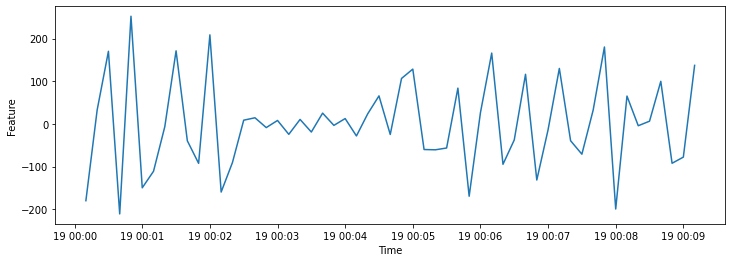

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(feature_train.diff(periods=1))
plt.xlabel('Time')
plt.ylabel('Feature')

In [11]:
dftest = adfuller(feature_train)
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -2.019
DF test p-value is 0.2782


The data is Stationary now, let us apply ARIMA on the differenced data set.



In [0]:
feature_train_diff = feature_train.diff(periods=1)
feature_train_diff.dropna(inplace=True)

feature_val_diff = feature_val.diff(periods=1)
feature_val_diff.dropna(inplace=True)

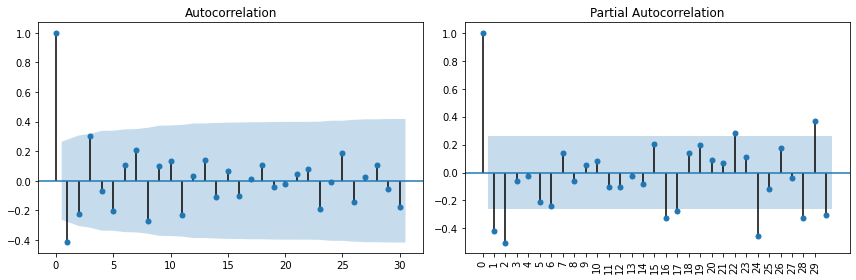

In [13]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(feature_train_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(feature_train_diff, lags=30, ax=axes[1])
plt.tight_layout()

The above ACF has “decayed” fast and remains within the significance range (blue band). This is indicative of a stationary series.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


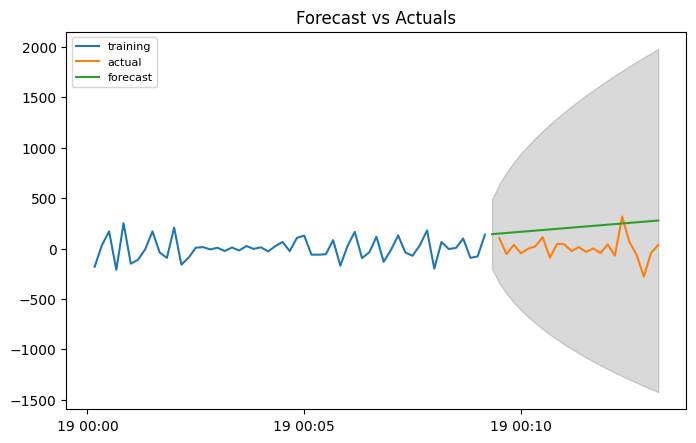

In [36]:
# Build Model 
model = ARIMA(feature_train_diff, order=(0,1,0)) #Chosen this combination of p,q,d after trying other combinations 
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(feature_train_diff, label='training')
plt.plot(feature_val_diff, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

###Validating Forecast

In [37]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'rmse':rmse})

forecast_accuracy(fc.reshape(24,1), val)

{'rmse': feature    109.138091
 dtype: float64}

In [38]:
forecast = fitted.forecast(steps=40)[0]
data_to_pred = pd.read_csv('/content/drive/My Drive/Internshala/test_csv.csv')
data_to_pred['forecast'] = forecast
data_to_pred.head()

,id,time,forecast
0,80,2019-03-19 00:13:20,143.074815
1,81,2019-03-19 00:13:30,148.949630
2,82,2019-03-19 00:13:40,154.824444
3,83,2019-03-19 00:13:50,160.699259
4,84,2019-03-19 00:14:00,166.574074


In [0]:
data_to_pred.to_excel('/content/drive/My Drive/Internshala/Solution.xlsx')